### Imports

In [1]:
import time
import random
import json
import lxml
import importlib
import os
import subprocess

import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import pandas as pd
import numpy as np
import pickle as pkl
import plotly.graph_objects as go
import umap.umap_ as umap
import tensorflow.keras
from matplotlib.pyplot import figure
plt.rcParams["font.family"] = "Times New Roman"

from plotly.subplots import make_subplots
from tqdm import tqdm
from tqdm.notebook import tqdm
from pandarallel import pandarallel
from ast import literal_eval
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

from gensim.models import Word2Vec
from gensim.models import word2vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import FastText
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec


from mol2vec import features
from mol2vec import helpers
from mol2vec.features import mol2alt_sentence, MolSentence, DfVec, sentences2vec
from mol2vec.helpers import depict_identifier, plot_2D_vectors, IdentifierTable, mol_to_svg

from Bio import SeqUtils

from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Conv1D, Flatten, MaxPooling1D,\
                        AveragePooling1D, Concatenate, LeakyReLU, Embedding,\
                        GlobalMaxPooling1D,GlobalAveragePooling1D,GaussianNoise,BatchNormalization,Add
from tensorflow.keras.initializers import glorot_uniform

from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report


from IPython.core.display import display, HTML
pandarallel.initialize(progress_bar = True)
tqdm.pandas()

/miniconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/miniconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/miniconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/miniconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/miniconda/lib/p

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### GPU Settings

In [2]:
str(subprocess.check_output('nvidia-smi', shell = True)).split('\\n')

["b'Wed Jun 16 20:56:23 2021       ",
 '+-----------------------------------------------------------------------------+',
 '| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |',
 '|-------------------------------+----------------------+----------------------+',
 '| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |',
 '| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |',
 '|===============================+======================+======================|',
 '|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |',
 '| N/A   65C    P0    30W /  70W |      0MiB / 15079MiB |      0%      Default |',
 '+-------------------------------+----------------------+----------------------+',
 '|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |',
 '| N/A   75C    P0    34W /  70W |      0MiB / 15079MiB |      0%      Default |',
 '+-------------------------------+---

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

### Class Definition

In [4]:
class AIBind():

    # Class Initialisation
    def __init__(self,

                 interactions_location = None,
                 interactions = None,
                 interaction_y_name = 'Y',
                 
                 absolute_negatives_location = None,
                 absolute_negatives = None,

                 drugs_location = None,
                 drugs_dataframe = None,
                 drug_inchi_name = None,
                 drug_smile_name = None,

                 targets_location = None,
                 targets_dataframe = None, 
                 target_seq_name = None,

                 mol2vec_location = None,
                 mol2vec_model = None,

                 protvec_location = None, 
                 protvec_model = None,

                 nodes_test = [], 
                 nodes_validation = [], 

                 edges_test = [], 
                 edges_validation = [], 

                 model_out_dir = None,

                 debug = False):

        '''
         Class initialisation

         Inputs : 

             Optional - one of two below
                 interactions_location : String - Location of interactions file (CSV / Pickle)
                 interactions : Pandas DataFrame - Interactions dataframe

             interaction_y_name : String - Column name for true variable in interactions file

             Optional - one of two below
                 drugs_location : String - Location of drugs file (CSV / Pickle)
                 drugs_dataframe : Pandas DataFrame - Drugs DataFrame
             drug_inchi_name : String - Column name of field that contains the InChi Key 
             drug_smile_name : String - Column name of field that contains the chemical SMILE

             Optional - one of two below
                 targets_location : String - Location of targets file (CSV / Pickle)
                 targets_dataframe : Pandas DataFrame - Targets DataFrame
             target_seq_name : String - Column name of field that contains the amino acid sequence

             Optional - one of two below
                 mol2vec_location : String - Location of Mol2Vec model file
                 mol2vec_model : Word2Vec - Word2Vec model

             Optional - one of two below
                 protvec_location : String - Location of ProtVec model file 
                 protvec_model : Pandas DataFrame - ProtVec model DataFrame

             nodes_test : List - List of DataFrames of test set where all nodes must be unseen in the train set
             nodes_validation : List - List of DataFrames of validation set where all nodes must be unseen in the train set

             edges_test : List - List of DataFrames of test set where the rows must be unseen in the train set
             edges_validation : List - List of DataFrames of validation set where the rows must be unseen in the train set

             model_out_dir : String - Path to save trained models

             debug : Bool - Flag to print debug lines

        '''

        # Set Variables
        self.interactions_location = interactions_location
        self.interactions = interactions
        self.interaction_y_name = interaction_y_name
        
        self.absolute_negatives_location = absolute_negatives_location
        self.absolute_negatives = absolute_negatives

        self.drugs_location = drugs_location
        self.drugs_dataframe = drugs_dataframe 
        self.drug_inchi_name = drug_inchi_name
        self.drug_smile_name = drug_smile_name

        self.targets_location = targets_location
        self.targets_dataframe = targets_dataframe
        self.target_seq_name = target_seq_name

        self.mol2vec_location = mol2vec_location
        self.mol2vec_model = mol2vec_model

        self.protvec_location = protvec_location
        self.protvec_model = protvec_model

        self.nodes_test = nodes_test
        self.nodes_validation = nodes_validation
        self.edges_test = edges_test
        self.edges_validation = edges_validation

        self.model_out_dir = model_out_dir

        self.debug = debug

        # Read In Drugs 
        if type(self.drugs_dataframe) == type(None):
            self.drugs_dataframe = self.read_input_files(self.drugs_location)

        # Read In Targets
        if type(self.targets_dataframe) == type(None):
            self.targets_dataframe = self.read_input_files(self.targets_location)

        # Create Drug Target Lists
        self.drug_list = list(self.drugs_dataframe[self.drug_inchi_name])
        self.target_list = list(self.targets_dataframe[self.target_seq_name])

        # Read In Interactions File
        if type(self.interactions) == type(None):
            self.interactions = self.read_input_files(self.interactions_location)
            
        # Read In Absolute Negatives File
        if type(self.absolute_negatives) == type(None):
            if type(self.absolute_negatives_location) != type(None):
                self.absolute_negatives = self.read_input_files(self.absolute_negatives_location)

        # Column Name Assertions 
        assert self.drug_inchi_name in self.interactions.columns, "Please ensure columns with InChi Keys have the same name across all dataframes"
        assert self.drug_inchi_name in self.drugs_dataframe.columns, "Please ensure columns with InChi Keys have the same name across all dataframes"

        if self.nodes_test != []:
            assert self.drug_inchi_name in self.nodes_test[0].columns, "Please ensure columns with InChi Keys have the same name across all dataframes"
            assert self.drug_inchi_name in self.nodes_validation[0].columns, "Please ensure columns with InChi Keys have the same name across all dataframes"
            assert self.drug_inchi_name in self.edges_test[0].columns, "Please ensure columns with InChi Keys have the same name across all dataframes"
            assert self.drug_inchi_name in self.edges_validation[0].columns, "Please ensure columns with InChi Keys have the same name across all dataframes"

        assert self.target_seq_name in self.interactions.columns, "Please ensure columns with Amino Acid Sequences have the same name across all dataframes"
        assert self.target_seq_name in self.targets_dataframe.columns, "Please ensure columns with Amino Acid Sequences have the same name across all dataframes"

        if self.nodes_test != []:
            assert self.target_seq_name in self.nodes_test[0].columns, "Please ensure columns with Amino Acid Sequences have the same name across all dataframes"
            assert self.target_seq_name in self.nodes_validation[0].columns, "Please ensure columns with Amino Acid Sequences have the same name across all dataframes"
            assert self.target_seq_name in self.edges_test[0].columns, "Please ensure columns with Amino Acid Sequences have the same name across all dataframes"
            assert self.target_seq_name in self.edges_validation[0].columns, "Please ensure columns withAmino Acid Sequences have the same name across all dataframes"


    ###################################################
    ############    General Functions      ############
    ###################################################

    # Read Input Files 
    def read_input_files(self, input_location):

        '''
        Reads in files into a dataframe given a file location. Currently works with CSV and Pickle files. 

        Inputs : 
            input_location : String - Location of file to read in - accepts only CSV and Pickle files
        Outputs : 
            Pandas DatraFrame 

        '''

        assert type(input_location) == type(""), 'Location should be of type str'

        if input_location.split('.')[-1] == 'pkl':
            with open(input_location, 'rb') as file: 
                return pkl.load(file)

        elif input_location.split('.')[-1] == 'csv':
            return pd.read_csv(input_location)

        else:
            raise TypeError("Unknown input file type, only pkl and csv are supported")

    def sub_len(self, input_list):
        '''
        Returns length of sub-lists

        Input :
            input_list : List - List of lists

        Output : 
            List of lenght of each sub list
        '''
        return [len(l) for l in input_list]

    def create_interaction_dicts(self, interactions):

        '''
            Creates dictionaries for drugs and targets of the form 
                InchiKey : {Y = 0 : [AA Seqs], Y = 1 : [AA Seqs]} 
                and 
                AA Seq  : {Y = 0 : [InChi Keys], Y = 1 : [InChi Keys]} 

            Inputs : 
                interactions : Pandas DataFrame - Pandas dataframe of interactions

            Outputs : 
                Dictionaries with InChi Key and AA Seq binding information as mentioned above
        '''

        drug_dict = {}
        target_dict = {}

        for i in tqdm(range(len(interactions))):

            drug_id = interactions['InChiKey'].values[i]
            target_id = interactions['target_aa_code'].values[i]
            binding = interactions['Y'].values[i]

            try:
                drug_dict[drug_id]
            except:
                drug_dict[drug_id] = {}

            try:
                drug_dict[drug_id][binding].append(target_id)
            except:
                drug_dict[drug_id][binding] = [target_id]

            try:
                target_dict[target_id]
            except:
                target_dict[target_id] = {}

            try:
                target_dict[target_id][binding].append(drug_id)
            except:
                target_dict[target_id][binding] = [drug_id]

        return drug_dict, target_dict

    def create_adjacency(self, drug_dict, target_dict, full = True, include_negative = False):

        '''
            Creates adjacency matrix out of dictionaries with InChiKey and AA Seq binding info

            Inputs : 
                drug_dict : Dictionary - Dict with InChiKey binding info
                target_dict : Dictionary - Dict with AA Seq binding info
                full : Bool - Boolean to determine whether to return a full adjacency matrix for a bipartite network
                include_negative : Bool - Boolean to determine if negative interactions should be included as '-1' in the adjacency matrix
            Outputs : 
                Adjacency matrix

        '''

        # Create Adjascency Matrix For Drugs x Amino Acids
        drug_list = list(drug_dict.keys())
        target_list = list(target_dict.keys())
        number_of_drugs = len(list(drug_dict.keys()))
        number_of_targets = len(list(target_dict.keys()))

        adjascency_matrix = np.zeros((number_of_drugs, number_of_targets))

        if include_negative == False: 
            for i in tqdm(range(number_of_drugs)):
                for j in range(number_of_targets):

                    try:
                        if target_list[j] in drug_dict[drug_list[i]][1]:
                            adjascency_matrix[i][j] = 1
                    except: 
                        None

                    try: 
                        if target_list[j] in drug_dict[drug_list[i]][0]:
                            adjascency_matrix[i][j] = 0
                    except: 
                        None

        else : 
            for i in tqdm(range(number_of_drugs)):
                for j in range(number_of_targets):

                    try:
                        if target_list[j] in drug_dict[drug_list[i]][1]:
                            adjascency_matrix[i][j] = 1
                    except: 
                        None

                    try: 
                        if target_list[j] in drug_dict[drug_list[i]][0]:
                            adjascency_matrix[i][j] = -1
                    except: 
                        None

        if full == False: 
            return adjascency_matrix

        else: 
            # Create full bipartite adjacency matrix
            true_adjacency_matrix_bipartite = np.block([
                [np.zeros((len(drug_dict), len(drug_dict))), adjascency_matrix],
                [adjascency_matrix.T, np.zeros((len(target_dict), len(target_dict)))]
            ])
            return true_adjacency_matrix_bipartite

    def create_n_hop_negatives(self, interactions = None, path_lower_bound = 10, path_upper_bound = 16, max_hop = 16, show_plot = False, return_negatives = False):

        '''
            Creates a dataframe with pairs that are n hops away from each other conditional on bounds specified

            Inputs : 
                interactions : Pandas DataFrame - Pandas Dataframe with drug target interactions
                path_lower_bound : Integer - All hops equal to or above path_lower_bound and lower than path_upper_bound are considered negative 
                path_upper_bound : Integer - All hops equal to or above path_lower_bound and lower than path_upper_bound are considered negative 
                max_hop : Integer - Compute hops upto this value
                show_plot : Bool - Plot histogram of hop distribution
                return_negatives : Bool - Return negatives dataframe

        '''

        if type(interactions) == type(None):
            print ("No interaction file given, using train interactions instead.")
            interactions = self.interactions

        # Create Drug and Target Dictionaries
        drug_dict, target_dict = self.create_interaction_dicts(interactions)

        # Create Adjacency Matrix For The Network From Above Dictionaries
        adjacency = self.create_adjacency(drug_dict, target_dict)

        # Create A List Of Degrees
        degree = np.sum(adjacency, axis = 0) + 1e-2

        num_nodes = adjacency.shape[0]

        # Compute hops 
        higher_adjacency_matrix = np.zeros((num_nodes, num_nodes, max_hop + 1))

        higher_adjacency_matrix[:,:,0] =  np.identity(num_nodes)

        for i in tqdm(range(1, max_hop)):
            higher_adjacency_matrix[:, :, i] = np.dot(higher_adjacency_matrix[:, :, i - 1], adjacency)

        higher_adjacency_matrix[:, :, max_hop] = np.ones((num_nodes, num_nodes))
        path_length = (higher_adjacency_matrix != 0).argmax(axis = 2)

        # Plot
        if show_plot: 
            plt.title("Path Lengths")
            plt.xlabel("Hop Distance")
            plt.ylabel("Frequency")
            plt.hist(path_length.flatten(), bins = list(range(0, max_hop + 1)))
            plt.show()

        # Get split points
        drug_split = len(drug_dict)
        target_split = len(target_dict)
        drug_list = list(drug_dict)
        target_list = list(target_dict)

        # Create Max Hop Negatives
        dataframe = []
        for i, j in tqdm(zip(*np.where((path_length >= path_lower_bound) & (path_length < path_upper_bound)))):
            if i < drug_split and j >= drug_split:
                dataframe.append([drug_list[i], target_list[j - drug_split], 0])

        self.negatives = pd.DataFrame(dataframe)
        self.negatives.columns = [self.drug_inchi_name, self.target_seq_name, self.interaction_y_name]

        if return_negatives:
            return self.negatives

    def create_test_splits(self, interactions = None, frac = 0.15, num_splits = 5, true_negatives_df = None, seed = 2021, update_dataframes = True, return_dataframes = False, debug = None):

        '''
        interactions : Pandas DataFrame - Pandas Dataframe with drug target interactions
        frac : Flaot -  Fraction of interactions to be considered for test and validation
        num_splits : Integer - Number of splits to create for the K fold cross validation process
        seed : Integer - Random seed initialisation
        update_dataframes : Bool - Update class variable with test and validation sets 
        return_dataframes : Bool - Return test and validation sets
        debug : Bool - Print debug info

        '''

        if type(debug) == type(None):
            debug = self.debug

        if type(interactions) == type(None):
            print ("No interaction file given, using train interactions instead.")
            interactions = self.interactions

        # Initial parameters
        np.random.seed(seed)
        random.seed(seed)

        targets = self.targets_dataframe
        num_in_split = targets.shape[0] // num_splits

        # Shuffle target list
        target_list = list(targets[self.target_seq_name])
        np.random.shuffle(target_list)

        # Unseen Targets 
        # Create Multiple Sets Of Unseen Targets
        unseen_target_sets = np.split(np.array(target_list),
                                      [num_in_split * i for i in range(1, num_splits)])

        # Create Seen Target Sets For Each Unseen Target Set Above
        seen_target_sets = [set(targets[self.target_seq_name]).difference(unseen_targets) for unseen_targets in unseen_target_sets]

        if debug : 
            print ("Number Of Unseen Targets In Each Set : ", self.sub_len(unseen_target_sets))
            print ("Number Of Seen Targets In Each Set : ", self.sub_len(seen_target_sets))

        # Create Set Of Seen Target DataFrames
        seen_target_pos_df_sets = [interactions[interactions[self.target_seq_name].isin(seen_targets)] 
                                   for seen_targets in seen_target_sets]

        # Create Set Of Unseen Target DataFrames
        unseen_target_pos_df_sets = [interactions[interactions[self.target_seq_name].isin(unseen_targets)] 
                                     for unseen_targets in unseen_target_sets]

        # Make DataFrames Prettier
        seen_target_pos_df_sets = [seen_target_df[[self.drug_inchi_name, self.target_seq_name, self.interaction_y_name]] for seen_target_df in seen_target_pos_df_sets]
        unseen_target_pos_df_sets = [unseen_target_df[[self.drug_inchi_name, self.target_seq_name, self.interaction_y_name]] for unseen_target_df in unseen_target_pos_df_sets]

        if debug: 
            print ("Length Of Unseen Target DataFrames (Positives Only) : ", self.sub_len(unseen_target_pos_df_sets))

        unseen_targets_df_sets = []

        for idx, unseen_target_df in enumerate(unseen_target_pos_df_sets):

            # Get Random Negative DataFrame
            neg_df = self.negatives[self.negatives[self.target_seq_name].isin(unseen_target_sets[idx])]

            # Figure Out Sample Ratio
            sample_ratio = max(self.sub_len(unseen_target_pos_df_sets)) / neg_df.shape[0]

            # Sample Negatives
            neg_df = neg_df.sample(frac = sample_ratio, replace = False)

            # Concatenate With Random Negatives
            unseen_target_df = pd.concat([unseen_target_df, neg_df])

            # Shuffle 
            unseen_target_df = unseen_target_df.sample(frac = 1.0, replace = False)

            # Append
            unseen_targets_df_sets.append(unseen_target_df)

        if debug: 
            print ("Length Of Unseen Targets DataFrames (Complete) : ", self.sub_len(unseen_targets_df_sets))

        # Unseen Edges
        unseen_edges_df_sets = []

        for idx, (seen_target_df, seen_targets) in enumerate(zip(seen_target_pos_df_sets, seen_target_sets)):

            # Get Random Negative DataFrame
            neg_df = self.negatives[self.negatives[self.target_seq_name].isin(seen_target_sets[idx])]

            # Sample From The Seen Target DataFrame
            unseen_edges_pos_df = seen_target_df.sample(frac = frac, replace = False).reset_index(drop = True)

            # Figure Out Sample Ratio
            sample_ratio = unseen_edges_pos_df.shape[0] / neg_df.shape[0]

            # Sample Negatives
            neg_df = neg_df.sample(frac = sample_ratio, replace = False)

            # Concatenate With Random Negatives
            unseen_edges_df = pd.concat([unseen_edges_pos_df, neg_df])

            # Shuffle 
            unseen_edges_df = unseen_edges_df.sample(frac = 1.0, replace = False)

            # Append
            unseen_edges_df_sets.append(unseen_edges_df)

        if debug: 
            print ("Length Of Unseen Edges DataFrames (Complete) : ", self.sub_len(unseen_edges_df_sets))

        # Target validation sets
        nodes_test = []
        nodes_validation = []

        for dataframe in tqdm(unseen_targets_df_sets):

            split_point = dataframe.shape[0] // 2
            split = np.split(dataframe, [split_point])
            nodes_test.append(split[0])
            nodes_validation.append(split[1])
        if debug :
            print ("Unseen Nodes/Targets ")
            print ("Shapes Of Validation Sets : ", self.sub_len(nodes_validation))
            print ("Shapes Of Test Sets : ", self.sub_len(nodes_test))

        # Edges Validation
        edges_test = []
        edges_validation = []

        for dataframe in tqdm(unseen_edges_df_sets):

            split_point = dataframe.shape[0] // 2
            split = np.split(dataframe, [split_point])
            edges_test.append(split[0])
            edges_validation.append(split[1])
        if debug : 
            print ("Unseen Edges")
            print ("Shapes Of Validation Sets : ", self.sub_len(edges_validation))
            print ("Shapes Of Test Sets : ", self.sub_len(edges_test))

        if type(self.absolute_negatives) != type(None) and type(true_negatives_df) == type(None):
            true_negatives_df = self.absolute_negatives
        
        # Update with true negatives
        if type(true_negatives_df) != type(None):

            # Ensure these drugs and targets are part of the drugs/targets dataframes
            # Only keep needed columns in drugs and targets dataframe
            self.drugs_dataframe = self.drugs_dataframe[[self.drug_inchi_name, self.drug_smile_name]]
            self.targets_dataframe = self.targets_dataframe[[self.target_seq_name]]

            # Concatenate with absolute negative data
            self.drugs_dataframe = pd.concat([self.drugs_dataframe, true_negatives_df[[self.drug_inchi_name, self.drug_smile_name]]]).drop_duplicates(keep = "first")
            self.targets_dataframe = pd.concat([self.targets_dataframe, true_negatives_df[[self.target_seq_name]]]).drop_duplicates(keep = "first")

            # Recreate drug and target lists 
            self.drug_list = list(self.drugs_dataframe[self.drug_inchi_name])
            self.target_list = list(self.targets_dataframe[self.target_seq_name])
            
            # Shuffle the dataframe
            true_negatives_df = true_negatives_df.sample(frac = 1)

            # Split into equal chunks 
            split_ratio = true_negatives_df.shape[0] // len(nodes_test)
            splits = np.split(true_negatives_df, [i * split_ratio for i in range(len(nodes_test))])

            # Add into test sets 
            for idx in range(len(nodes_test)):
                nodes_test[idx] = pd.concat([nodes_test[idx], splits[idx]])

        if update_dataframes:
            self.nodes_test = nodes_test
            self.nodes_validation = nodes_validation
            self.edges_test = edges_test
            self.edges_validation = edges_validation

        if return_dataframes : 
            return nodes_test, nodes_validation, edges_test, edges_validation

    def create_train_sets(self, unseen_nodes_flag = True, data_leak_check = True):   

        '''
            Creates train sets by ensuring exclusitivity between test and validation sets. 

            Inputs : 
                unseen_nodes_flag : Bool - Ensures drugs and targets are both unseen in the train set if true. Only ensures unseen targets if false/
                data_leak_check : Bool - Performs sanity checks to ensure no data leakage between train / validation and test sets

        ''' 

        self.train_sets = []
        self.train_pos_neg_ratio = []

        for i in tqdm(range(len(self.nodes_test))):

            # Unseen Targets
            unseen_targets = list(set(self.nodes_test[i][self.target_seq_name])) + list(set(self.nodes_validation[i][self.target_seq_name]))

            # Unseen Drugs
            unseen_drugs = list(set(self.nodes_test[i][self.drug_inchi_name])) + list(set(self.nodes_validation[i][self.drug_inchi_name]))

            # Seen Targets
            seen_targets = set(self.targets_dataframe[self.target_seq_name]).difference(unseen_targets)

            # Seen Drugs
            seen_drugs = set(drugs[self.drug_inchi_name]).difference(unseen_drugs)

            # Seen Targets 
            seen_target_df = self.interactions[self.interactions[self.target_seq_name].isin(seen_targets)]
            seen_target_df = seen_target_df[[self.drug_inchi_name, self.target_seq_name, self.interaction_y_name]]

            # Create dataframe with train interactions
            # pd.concat + drop duplicates amounts to a set interesection
            train_interactions = pd.concat([seen_target_df,
                                            self.edges_test[i],
                                            self.edges_test[i],
                                            self.edges_validation[i],
                                            self.edges_validation[i]]).drop_duplicates(keep = False)

            # Ensure unseen nodes if flag is on, else train sets only satisfy unseen targets criteria
            if unseen_nodes_flag: 
                # Ensure Unseen Drugs
                train_interactions = train_interactions.reset_index(drop = True)
                drop_index = []
                for idx, row in tqdm(train_interactions.iterrows()):
                    if row[self.drug_inchi_name] in unseen_drugs:
                        drop_index.append(idx)
                train_interactions.drop(train_interactions.index[drop_index], inplace = True)

            self.train_sets.append(train_interactions)
            self.train_pos_neg_ratio.append(1 / np.divide(*np.array(train_interactions['Y'].value_counts().values)))

        # Sanity check section
        if data_leak_check:
            for i in range(len(self.nodes_test)):

                print ("Set : ", i)

                # No Overlap Between Unseen Nodes and Train
                unseen_targets = list(set(self.nodes_test[i][self.target_seq_name])) + list(set(self.nodes_validation[i][self.target_seq_name]))
                print ("Train - Test - Validation Overlap For Unseen Targets : ", len(list(set(self.train_sets[i][self.target_seq_name]).intersection(unseen_targets))))

                if unseen_nodes_flag:
                    # No overlap Between Drugs
                    unseen_drugs = list(set(self.nodes_test[i][self.drug_inchi_name])) + list(set(self.nodes_validation[i][self.drug_inchi_name]))
                    print ("Train - Test - Validation Overlap For Unseen Drugs : ", len(list(set(self.train_sets[i][self.drug_inchi_name]).intersection(unseen_drugs))))


                # No Overlap Between Unseen Edges and Train
                train_edges = list(zip(list(self.train_sets[i][self.drug_inchi_name]), list(self.train_sets[i][self.target_seq_name])))
                temp_df = pd.concat([self.edges_test[i], self.edges_validation[i]])
                test_edges = list(zip(list(temp_df[self.drug_inchi_name]), list(temp_df[self.target_seq_name])))
                train_edges = set(train_edges)
                test_edges = set(test_edges)
                print ("Train - Test - Validation Overlap For Unseen Edges : ", len(list(train_edges.intersection(test_edges))))

                print ("Train Set : ", self.train_sets[i].shape)
                print ("Nodes Test : ", self.nodes_test[i].shape)
                print ("Nodes Val : ", self.nodes_validation[i].shape)
                print ("Edge Test : ", self.edges_test[i].shape)
                print ("Edge Val : ", self.edges_validation[i].shape)
                print ("Positive / Negatative Ratio : ", self.train_pos_neg_ratio[i])
                print ("")

    def dataframe_to_embed_array(self, interactions_df, drug_list, target_list, drug_embed_len, normalized_drug_embeddings = None, normalized_target_embeddings = None, include_true_label = True):

        '''
            Creates numpy arrays that can be fed into the model from interaction dataframes. 

            Inputs : 
                interactions_df : Pandas DataFrame - Pandas dataframe containing interactions
                drug_list : List - List of drug InChi Keys
                target_list : List - List of target AA Sequences
                drug_embed_len : Integer - Length of drug embedding vector

            Outputs : 
                X_0 : Numpy Array - Array with target vectors
                X_1 : Numpy Array - Array with drug vectors
                Y :  Numpy Array - Array with true labels
        '''

        X_0_list = []
        X_1_list = []

        if type(normalized_target_embeddings) == type(None):
            normalized_target_embeddings = self.normalized_target_embeddings

        if type(normalized_drug_embeddings) == type(None):
            normalized_drug_embeddings = self.normalized_drug_embeddings

        skipped_drugs = 0

        # Iterate over all rows in dataframe
        for idx, row in interactions_df.iterrows():

            # Get InChiKey and AA Sequence
            drug = row[self.drug_inchi_name]
            target = row[self.target_seq_name]

            # Get drug index for this drug in drug_list
            try:
                drug_index = drug_list.index(drug)
            except: 
                drug_index = -1

            # Get target index for this target in target_list
            target_index = target_list.index(target)

            # Index into target embedding array and add to X_0
            X_0_list.append(normalized_target_embeddings[target_index])

            # If drug index not found, add random vector to X_1
            if drug_index == -1:
                X_1_list.append(np.random.randn(drug_embed_len,))
                skipped_drugs = skipped_drugs + 1
            else:
                # Index into drug embedding array and add to X_1
                try:
                    X_1_list.append(normalized_drug_embeddings[drug_index])
                # If drug index not found, add random vector to X_1
                except: 
                    X_1_list.append(np.random.randn(drug_embed_len,))
                    skipped_drugs = skipped_drugs + 1

        # Convert lists to arrays
        X_0 = np.array(X_0_list)
        X_1 = np.array(X_1_list)

        if self.debug:
            print ("Number of drugs skipped : ", skipped_drugs)

        if include_true_label:
            Y = np.array(list(interactions_df['Y']))
            return X_0, X_1, Y
        else: 
            return X_0, X_1

    def get_validation_results(self, model_name = None, version_number = None, show_plots = True, plot_title = None, num_cols = 2, plot_height = 1500, plot_width = 1500, write_plot_to_html = False, plot_dir = None, plot_name = None):

        '''
            Computes validation results 

            Inputs : 
                model_name : String - Key of model used while trainig. If None, class variable will be picked up
                version_number : Integer - Version number for the model 
                show_plots : Bool - Show learning curve plots
                plot_title : String - Title for learning curve plots
                num_cols : Integer - Number of columns in learning curve plot grid - rows are automatically calculated
                plot_height : Integer - Plot height in pixels
                plot_width : Integer - Plot width in pixels
                write_plot_to_html : Bool - Save plot to disk in HTML format (interactive)
                plot_dir : String - Path to save plot 
                plot_name : String - Name of saved plot

            Outputs : 
                Updates optimal validation epoch to self.optimal_validation_model

        '''

        self.averaged_results = {}

        if type(model_name) != type(None) and type(version_number) == type(None):
            raise ValueError ("Please enter a version number for this model")

        if type(model_name) == type(None):
            model_name = list(self.results.keys())[0]
        else: 
            model_name = model_name + '_v' + str(version_number)

        num_rows = (len(self.train_sets) // num_cols) + (len(self.train_sets) % num_cols)

        fig = make_subplots(
            rows = num_rows, cols = num_cols,
            subplot_titles = [' ' for _ in range(num_rows * num_cols)])

        row_counter = 1
        col_counter = 1

        # Get length of the x axis to ensure avergaes make sense 
        x_length = [len(self.results[model_name][run]['val_auc_ut']) for run in self.results[model_name].keys()]
        # Pick the length that is most common to compute aligned averages
        x_length = list(Counter(x_length))[0]

        for run in self.results[model_name].keys():

            # Plot legend only once
            if run == 0:
                legend = True
            else: 
                legend = False

            # X axis list
            x_list = [x for x in range(len(self.results[model_name][run]['val_auc_ut']))]

            # Ensure lengths match up 
            if len(x_list) == x_length:

                # Save validation AUC averaged scores for Unseen Nodes
                if 'val_auc_ut' in self.averaged_results:
                    self.averaged_results['val_auc_ut'] = self.averaged_results['val_auc_ut'] + np.array(self.results[model_name][run]['val_auc_ut']).reshape(-1, 1)
                elif 'val_auc_ut' not in self.averaged_results: 
                    self.averaged_results['val_auc_ut'] = np.array(self.results[model_name][run]['val_auc_ut']).reshape(-1, 1)

                # Save validation AUC averaged scores for Unseen Edges
                if 'val_auc_ue' in self.averaged_results:
                    self.averaged_results['val_auc_ue'] = self.averaged_results['val_auc_ue'] + np.array(self.results[model_name][run]['val_auc_ue']).reshape(-1, 1)
                elif 'val_auc_ue' not in self.averaged_results: 
                    self.averaged_results['val_auc_ue'] = np.array(self.results[model_name][run]['val_auc_ue']).reshape(-1, 1)

                # Save validation AUP averaged scores for Unseen Nodes
                if 'val_aup_ut' in self.averaged_results:
                    self.averaged_results['val_aup_ut'] = self.averaged_results['val_aup_ut'] + np.array(self.results[model_name][run]['val_aup_ut']).reshape(-1, 1)
                elif 'val_aup_ut' not in self.averaged_results: 
                    self.averaged_results['val_aup_ut'] = np.array(self.results[model_name][run]['val_aup_ut']).reshape(-1, 1)

                # Save validation AUP averaged scores for Unseen Edges
                if 'val_aup_ue' in self.averaged_results:
                    self.averaged_results['val_aup_ue'] = self.averaged_results['val_aup_ue'] + np.array(self.results[model_name][run]['val_aup_ue']).reshape(-1, 1)
                elif 'val_aup_ue' not in self.averaged_results: 
                    self.averaged_results['val_aup_ue'] = np.array(self.results[model_name][run]['val_aup_ue']).reshape(-1, 1)

            if show_plots:
                # Plot validation AUC for Unseen Nodes    


                fig.add_trace(go.Scatter(x = x_list,
                                         y = self.results[model_name][run]['val_auc_ut'],
                                         mode = 'lines',
                                         name = 'Unseen Targets AUC',
                                         line_color = 'deepskyblue',
                                         legendgroup = str(run),
                                         showlegend = legend),
                             row = row_counter,
                             col = col_counter )


                # Plot validation AUC for Unseen Edges
                fig.add_trace(go.Scatter(x = x_list,
                                         y = self.results[model_name][run]['val_auc_ue'],
                                         mode = 'lines',
                                         name = 'Unseen Edges AUC',
                                         line_color = 'blue',
                                         legendgroup = str(run),
                                         showlegend = legend),
                             row = row_counter,
                             col = col_counter )



                # Plot validation AUP for Unseen Nodes
                fig.add_trace(go.Scatter(x = x_list,
                                         y = self.results[model_name][run]['val_aup_ut'],
                                         mode = 'lines',
                                         name = 'Unseen Targets AUP',
                                         line_color = 'red',
                                         legendgroup = str(run),
                                         showlegend = legend),
                             row = row_counter,
                             col = col_counter )


                # Plot validation AUP for Unseen Edges
                fig.add_trace(go.Scatter(x = x_list,
                                         y = self.results[model_name][run]['val_aup_ue'],
                                         mode = 'lines',
                                         name = 'Unseen Edges AUP',
                                         line_color = 'green',
                                         legendgroup = str(run),
                                         showlegend = legend),
                             row = row_counter,
                             col = col_counter)


                fig.update_xaxes(title_text = "Epochs * Chunks", row = row_counter, col = col_counter)
                fig.update_yaxes(title_text = "Performance", row = row_counter, col = col_counter)
                fig.layout.annotations[run]['text'] = model_name + " Run " + str(run)

                if col_counter == num_cols: 
                    col_counter = 1
                    row_counter = row_counter + 1
                else: 
                    col_counter = col_counter + 1



            # Averaged Results Plot
            avg_fig = go.Figure()

            x_list = [x for x in range(len(self.averaged_results['val_auc_ut']))]

            avg_fig.add_trace(go.Scatter(x = x_list,
                                         y = (self.averaged_results['val_auc_ut'] / len(x_list)).ravel(),
                                         mode = 'lines',
                                         name = 'Unseen Targets AUC',
                                         line_color = 'deepskyblue'),
                         )

            avg_fig.add_trace(go.Scatter(x = x_list,
                                         y = (self.averaged_results['val_auc_ue'] / len(x_list)).ravel(),
                                         mode = 'lines',
                                         name = 'Unseen Edges AUC',
                                         line_color = 'blue'),
                         )

            avg_fig.add_trace(go.Scatter(x = x_list,
                                         y = (self.averaged_results['val_aup_ut'] / len(x_list)).ravel(),
                                         mode = 'lines',
                                         name = 'Unseen Targets AUP',
                                         line_color = 'red'),
                         )

            avg_fig.add_trace(go.Scatter(x = x_list,
                                         y = (self.averaged_results['val_aup_ue'] / len(x_list)).ravel(),
                                         mode = 'lines',
                                         name = 'Unseen Edges AUP',
                                         line_color = 'green'),
                         )





        # Optimal epoch
        perf = np.zeros((self.averaged_results['val_aup_ue'].shape[0], 4))
        ut_c = 0
        ut_p = 1
        ue_c = 2
        ue_p = 3

        perf[:, ut_c] = self.averaged_results['val_auc_ut'].ravel()
        perf[:, ut_p] = self.averaged_results['val_aup_ut'].ravel()
        perf[:, ue_c] = self.averaged_results['val_auc_ue'].ravel()
        perf[:, ue_p] = self.averaged_results['val_aup_ue'].ravel()
        perf = perf / self.averaged_results['val_aup_ue'].shape[0]

        # UT AUC + UE AUC
        edge_target = np.argmax(np.sum(perf[:, [ut_c, ue_c]], axis = 1))

        # UT AUC + UT AUP
        target_only = np.argmax(np.sum(perf[:, [ut_c, ut_p]], axis = 1))

        # UE AUC + UE AUP
        edge_only = np.argmax(np.sum(perf[:, [ue_c, ue_p]], axis = 1))

        print ("(Epoch * Chunk) With Highest Unseen Node and Edge Score : ", edge_target)
        print ("(Epoch * Chunk) With Highest Unseen Node Score : ", target_only)
        print ("(Epoch * Chunk) With Highest Unseen Edge Score : ", edge_target)

        ut_auc = []
        ut_aup = []
        ue_auc = []
        ue_aup = []

        model_key = model_name
        best_model = edge_target

        for run in self.results[model_key].keys():

            ut_auc.append(self.results[model_key][run]['val_auc_ut'][best_model])
            ut_aup.append(self.results[model_key][run]['val_aup_ut'][best_model])
            ue_auc.append(self.results[model_key][run]['val_auc_ue'][best_model])
            ue_aup.append(self.results[model_key][run]['val_aup_ue'][best_model])

        print ("Validation Performance")
        print ("Best Model Suffix : ", self.model_name_index[model_name][best_model])
        print ("Unseen Node AUC : ", np.mean(ut_auc), "+/-", np.std(ut_auc))
        print ("Unseen Node AUP : ", np.mean(ut_aup), "+/-", np.std(ut_aup))
        print ("Unseen Edges AUC : ", np.mean(ue_auc), "+/-", np.std(ue_auc))
        print ("Unseen Edges AUP : ", np.mean(ue_aup), "+/-", np.std(ue_aup))


        try: 
            self.optimal_validation_model
        except: 
            self.optimal_validation_model = {}

        self.optimal_validation_model[model_name] = best_model


        if show_plots:
            fig.update_layout(title_text = plot_title, 
                                  height = plot_height,
                                  width = plot_width,
                                  showlegend = True)
            fig.show()

            avg_fig.update_layout(title_text = plot_title + " - Averaged Results Across " + str(len(x_list)) + " Runs", 
                              xaxis_title_text = 'Epochs * Chunks',
                              yaxis_title_text = 'Performance',
                              showlegend = True)
            avg_fig.show()

            if write_plot_to_html:
                fig.write_html(plot_dir.rstrip('/') + plot_name + '_k_fold_split_plots.html')
                avg_fig.write_html(plot_dir.rstrip('/') + plot_name + '_averaged_results_plots.html')

    def get_fold_averaged_prediction_results(self, model_name = None, version_number = None, model_paths = [], optimal_validation_model = None, test_sets = [], get_drug_embed = False, get_target_embed = True,  drug_filter_list = [], target_filter_list = [], return_dataframes = False):

        '''
            Computes test results, but averages predictions for each pair across all K folds
            Inputs : 
                model_name : String - Key of model used while trainig. If None, class variable will be picked up
                version_number : Integer - Version number of model trained 
                model_paths : List - List of complete paths to external models 
                optimal_validation_model : Integer - Index of optimal epoch to use 
                test_sets : List - List of test set dataframes 
                get_drug_embed : Bool - If prediction dataset has drugs that completely overlap with train / test, then set to false, else set to true to generate embeddings
                get_target_embed : Bool - If prediction dataset has targets that completely overlap with train / test, then set to false, else set to true to generate embeddings 
                drug_filter_list : List - List of InChi keys to filter and test on 
                target_filter_list : List - List of AA Sequences to filter and test on 
        '''

        # Initialise dictionary
        try: 
            self.fold_test_results
        except: 
            self.fold_test_results = {}

        if type(model_name) != type(None) and type(version_number) == type(None):

            raise ValueError("Please enter a version number with the model name")

        if type(model_name) == type(None):
                try:
                    model_name = list(self.results.keys())[0]
                except: 
                    model_name = ""

        else: 
            model_name = model_name + "_v" + str(version_number)

        if model_paths == []:
            if type(optimal_validation_model) == type(None):    
                optimal_validation_model = self.optimal_validation_model[model_name]

                for model_run_number in range(len(self.train_sets)):

                    model_prefix = "_".join(os.listdir(self.model_out_dir[model_name].rstrip('/') + '/Run_' + str(model_run_number))[0].split('_')[:-4])
                    model_suffix = self.model_name_index[model_name][optimal_validation_model]
                    model_location = self.model_out_dir[model_name].rstrip('/') + '/Run_' + str(model_run_number) + '/' + model_prefix + model_suffix

                    model_paths.append(model_location)


        if model_name not in self.fold_test_results.keys():
            self.fold_test_results[model_name] = {}

        if test_sets == []:
            print ("No test set given, predicting on class variable")
            test_sets = self.nodes_test

        # Create list to hold predictions across folds 
        prediction_unseen_targets = {'model_' + str(x) : ['' for _ in range(len(test_sets))] for x in range(len(model_paths))}
        # true_unseen_targets = {'model_' + str(x) : ['' for _ in range(len(test_sets))] for x in range(len(model_paths))}



        # Iterate over all models 
        for model_run_number in range(len(model_paths)):

            model_location = model_paths[model_run_number]

            print ("Testing on model : ", model_location)
            model = load_model(model_location)

            # Iterate over all sets 
            for sets_run_number in range(len(test_sets)):

                drug_embed_len = self.normalized_drug_embeddings[0].shape[0]

                filtered_nodes_test = test_sets[sets_run_number]


                if drug_filter_list != [] and target_filter_list != []:
                    filtered_nodes_test = filtered_nodes_test[(filtered_nodes_test[self.drug_inchi_name].isin(drug_filter_list)) & (filtered_nodes_test[self.target_seq_name].isin(target_filter_list))]

                elif drug_filter_list != [] and target_filter_list == []:
                    filtered_nodes_test = filtered_nodes_test[(filtered_nodes_test[self.drug_inchi_name].isin(drug_filter_list))]

                elif drug_filter_list == [] and target_filter_list != []:
                    filtered_nodes_test = filtered_nodes_test[(filtered_nodes_test[self.target_seq_name].isin(target_filter_list))]

                else: 
                    None
                    
                print ("filtered_nodes_test : ", filtered_nodes_test.shape)
                print ("Drugs : ", len(list(set(filtered_nodes_test[self.drug_inchi_name]))))
                print ("Targets : ", len(list(set(filtered_nodes_test[self.target_seq_name]))))

                # if sets_run_number not in self.fold_test_results[model_name].keys(): 
                self.fold_test_results[model_name][sets_run_number] = filtered_nodes_test

                # Get embeddings for prediction sets
                if get_target_embed: 
                    pred_targets_dataframe = self.get_protvec_embeddings(prediction_interactions = filtered_nodes_test,
                                                                         embedding_dimension = 100,
                                                                         replace_dataframe = False,
                                                                         return_normalisation_conststants = False,
                                                                         delimiter = '\t')
                else: 
                    pred_targets_dataframe = self.targets_dataframe[self.targets_dataframe[self.target_seq_name].isin(list(filtered_nodes_test[self.target_seq_name]))]
                    print ("pred_targets_dataframe : ", pred_targets_dataframe.shape)

                pred_target_list = list(pred_targets_dataframe[self.target_seq_name])
                pred_normalized_target_embeddings = np.array(list(pred_targets_dataframe['normalized_embeddings']))


                if get_drug_embed: 
                    pred_drugs_dataframe = self.get_mol2vec_embeddings(prediction_interactions = filtered_nodes_test,
                                                                       embedding_dimension = 300,
                                                                       replace_dataframe = False,
                                                                       return_normalisation_conststants = False)

                    
                    
                else: 
                    pred_drugs_dataframe = self.drugs_dataframe[self.drugs_dataframe[self.drug_inchi_name].isin(list(filtered_nodes_test[self.drug_inchi_name]))]
                    print ("pred_drugs_dataframe : ", pred_drugs_dataframe.shape)

                pred_drug_list = list(pred_drugs_dataframe[self.drug_inchi_name])
                pred_normalized_drug_embeddings = np.array(list(pred_drugs_dataframe['normalized_embeddings']))

                drug_embed_len = pred_normalized_drug_embeddings[0].shape[0]

                X_0_test_ut, X_1_test_ut = self.dataframe_to_embed_array(interactions_df = filtered_nodes_test,
                                                                         drug_list = pred_drug_list,
                                                                         target_list = pred_target_list,
                                                                         drug_embed_len = drug_embed_len,
                                                                         normalized_drug_embeddings = pred_normalized_drug_embeddings,
                                                                         normalized_target_embeddings = pred_normalized_target_embeddings,
                                                                         include_true_label = False)


                print ("X0, X1 : ",  X_0_test_ut.shape, X_1_test_ut.shape)

                # Test on unseen nodes
                Y_test_predictions_ut = []
                Y_test_predictions_ut.extend(model.predict([X_0_test_ut, X_1_test_ut]))
                Y_test_predictions_ut = [x[0] if not np.isnan(x[0]) else 0 for x in Y_test_predictions_ut]

                pred = Y_test_predictions_ut

                prediction_unseen_targets['model_' + str(model_run_number)][sets_run_number] = pred




        # Calculate mean - one dataset, all models
        for sets_run_number in range(len(test_sets)):

            unseen_targets_pred = []

            for model_run_number in range(len(model_paths)):

                unseen_targets_pred.append(prediction_unseen_targets['model_' + str(model_run_number)][sets_run_number])
            
            
            unseen_targets_pred = np.mean(np.array(unseen_targets_pred), axis = 0)
            print ("unseen_targets_pred : ", unseen_targets_pred.shape)
            print ("list : ", len(list(unseen_targets_pred)))
            
            # Update DataFrames
            self.fold_test_results[model_name][sets_run_number]['Averaged Predictions'] = list(unseen_targets_pred)

        if return_dataframes:
            return self.fold_test_results[model_name]

    def get_test_results(self, model_name = None, version_number = None, optimal_validation_model = None, drug_filter_list = [], target_filter_list = [], write_plot_to_disk = False, plot_dir = None, plot_name = None):

        '''
            Computes test results 

            Inputs : 
                model_name : String - Key of model used while trainig. If None, class variable will be picked up
                optimal_validation_model : Integer - Index of optimal epoch to use 
                version_number : Integer - Enter version number of the model 
                drug_filter_list : List - List of InChi keys to filter and test on 
                target_filter_list : List - List of AA Sequences to filter and test on 

        '''

        # Initialise dictionary
        try: 
            self.test_results
        except: 
            self.test_results = {}

        if type(model_name) != type(None) and type(version_number) == type(None):
            raise ValueError("Please enter a version number for the model")

        if type(model_name) == type(None):
                model_name = list(self.results.keys())[0]
        else: 
            model_name = model_name + "_v" + str(version_number)

        if type(optimal_validation_model) == type(None):    
            optimal_validation_model = self.optimal_validation_model[model_name]

        if model_name not in self.test_results.keys():
            self.test_results[model_name] = {}

        for run_number in range(len(self.train_sets)):

            model_prefix = "_".join(os.listdir(self.model_out_dir[model_name].rstrip('/') + '/Run_' + str(run_number))[0].split('_')[:-4])
            model_suffix = self.model_name_index[model_name][optimal_validation_model]
            model_location = model_prefix + model_suffix

            print ("Testing on model : ", model_location)

            drug_embed_len = self.normalized_drug_embeddings[0].shape[0]

            filtered_nodes_test = self.nodes_test[run_number]
            filtered_edges_test = self.edges_test[run_number]

            if drug_filter_list != [] and target_filter_list != []:
                filtered_nodes_test = filtered_nodes_test[(filtered_nodes_test[self.drug_inchi_name].isin(drug_filter_list)) & (filtered_nodes_test[self.target_seq_name].isin(target_filter_list))]
                filtered_edges_test = filtered_edges_test[(filtered_edges_test[self.drug_inchi_name].isin(drug_filter_list)) & (filtered_edges_test[self.target_seq_name].isin(target_filter_list))]

            elif drug_filter_list != [] and target_filter_list == []:
                filtered_nodes_test = filtered_nodes_test[(filtered_nodes_test[self.drug_inchi_name].isin(drug_filter_list))]
                filtered_edges_test = filtered_edges_test[(filtered_edges_test[self.drug_inchi_name].isin(drug_filter_list))]

            elif drug_filter_list == [] and target_filter_list != []:
                filtered_nodes_test = filtered_nodes_test[(filtered_nodes_test[self.target_seq_name].isin(target_filter_list))]
                filtered_edges_test = filtered_edges_test[(filtered_edges_test[self.target_seq_name].isin(target_filter_list))]

            else: 
                None




            X_0_test_ut, X_1_test_ut, Y_test_actual_ut = self.dataframe_to_embed_array(interactions_df = filtered_nodes_test,
                                                                              drug_list = self.drug_list,
                                                                              target_list = self.target_list,
                                                                              drug_embed_len = drug_embed_len)

            X_0_test_ue, X_1_test_ue, Y_test_actual_ue = self.dataframe_to_embed_array(interactions_df = filtered_edges_test,
                                                                                  drug_list = self.drug_list,
                                                                                  target_list = self.target_list,
                                                                                  drug_embed_len = drug_embed_len)

            model = load_model(self.model_out_dir[model_name].rstrip('/') + '/Run_' + str(run_number) + '/' + model_location)

            # Test on unseen nodes
            Y_test_predictions_ut = []
            Y_test_predictions_ut.extend(model.predict([X_0_test_ut, X_1_test_ut]))
            Y_test_predictions_ut = [x[0] if not np.isnan(x[0]) else 0 for x in Y_test_predictions_ut]

            true = Y_test_actual_ut
            pred = Y_test_predictions_ut

            f1_scores = []

            for j in np.arange(0.0, 1.0, 0.01):
                f1_scores.append(f1_score(true, [1 if (i > j) else 0 for i in pred]))

            f_1_thresh = [idx for idx, x in list(zip(np.arange(0.0, 1.0, 0.01), f1_scores)) if x == max(f1_scores)][0]

            pred_bin = [1 if (i > f_1_thresh) else 0 for i in pred]


            try: 
                self.test_results[model_name][run_number]
            except:
                self.test_results[model_name][run_number] = {}

            self.test_results[model_name][run_number]['unseen_targets_auc'] = roc_auc_score(true, pred)
            self.test_results[model_name][run_number]['unseen_targets_aup'] = average_precision_score(true, pred)
            self.test_results[model_name][run_number]['unseen_targets_f1_scores'] = f1_scores
            self.test_results[model_name][run_number]['unseen_targets_max_f1'] = np.max(f1_scores)
            self.test_results[model_name][run_number]['unseen_targets_f1_threshold'] = f_1_thresh
            self.test_results[model_name][run_number]['targets_confusion_matrix'] = confusion_matrix(true, pred_bin)

            # Test on unseen edges
            Y_test_predictions_ue = []
            Y_test_predictions_ue.extend(model.predict([X_0_test_ue, X_1_test_ue]))
            Y_test_predictions_ue = [x[0] if not np.isnan(x[0]) else 0 for x in Y_test_predictions_ue]

            true = Y_test_actual_ue
            pred = Y_test_predictions_ue

            f1_scores = []

            for j in np.arange(0.0, 1.0, 0.01):
                f1_scores.append(f1_score(true, [1 if (i > j) else 0 for i in pred]))

            f_1_thresh = [idx for idx, x in list(zip(np.arange(0.0, 1.0, 0.01), f1_scores)) if x == max(f1_scores)][0]

            pred_bin = [1 if (i > f_1_thresh) else 0 for i in pred]

            self.test_results[model_name][run_number]['unseen_edges_auc'] = roc_auc_score(true, pred)
            self.test_results[model_name][run_number]['unseen_edges_aup'] = average_precision_score(true, pred)
            self.test_results[model_name][run_number]['unseen_edges_f1_scores'] = f1_scores
            self.test_results[model_name][run_number]['unseen_edges_max_f1'] = np.max(f1_scores)
            self.test_results[model_name][run_number]['unseen_edges_f1_threshold'] = f_1_thresh
            self.test_results[model_name][run_number]['edges_confusion_matrix'] = confusion_matrix(true, pred_bin)

        ue_auc = []
        ue_aup = []
        ut_auc = []
        ut_aup = []
        f1_t_e = []
        f1_t_t = []
        f1_t = []
        f1_e = []
        all_f1_t = []
        all_f1_e = []

        conf_t = []
        conf_e = []


        for run_number in self.test_results[model_name].keys():

            # Averaged confusion matrix 
            conf_tot_t = np.sum(self.test_results[model_name][run_number]['targets_confusion_matrix'], axis = 0)
            conf_tot_e = np.sum(self.test_results[model_name][run_number]['edges_confusion_matrix'], axis = 0)

            ue_auc.append(self.test_results[model_name][run_number]['unseen_edges_auc'])
            ue_aup.append(self.test_results[model_name][run_number]['unseen_edges_aup'])
            ut_auc.append(self.test_results[model_name][run_number]['unseen_targets_auc'])
            ut_aup.append(self.test_results[model_name][run_number]['unseen_targets_aup'])
            f1_t_e.append(self.test_results[model_name][run_number]['unseen_edges_f1_threshold'])
            f1_t_t.append(self.test_results[model_name][run_number]['unseen_targets_f1_threshold'])    
            f1_t.append(self.test_results[model_name][run_number]['unseen_targets_max_f1'])
            f1_e.append(self.test_results[model_name][run_number]['unseen_edges_max_f1'])
            all_f1_t.append(self.test_results[model_name][run_number]['unseen_targets_f1_scores'])
            all_f1_e.append(self.test_results[model_name][run_number]['unseen_edges_f1_scores'])
            if self.test_results[model_name][run_number]['targets_confusion_matrix'][0][0] != 0:
                conf_t.append(self.test_results[model_name][run_number]['targets_confusion_matrix'] / conf_tot_t)
                conf_e.append(self.test_results[model_name][run_number]['edges_confusion_matrix'] / conf_tot_e)

        # Compute mean and error bars for F1 plots
        all_f1_t_err = np.std(np.array(all_f1_t), axis = 0)
        all_f1_e_err = np.std(np.array(all_f1_e), axis = 0)
        all_f1_t = np.mean(np.array(all_f1_t), axis = 0)
        all_f1_e = np.mean(np.array(all_f1_e), axis = 0)

        # Compute mean and deviation for the confusion matrix 
        target_conf = np.zeros((2, 2), dtype = object)
        t_conf_mean = np.mean(conf_t, axis = 0)
        t_conf_err = np.std(conf_t, axis = 0)

    
        if len(conf_t) != 0:
            for i in range(2):
                for j in range(2):
                    target_conf[i][j] = str(np.round(t_conf_mean[i][j], 2)) + " +/- " + str(np.round(t_conf_err[i][j], 2))
        target_conf = pd.DataFrame(target_conf) 

        results_df = pd.DataFrame(np.zeros((4, 2), dtype = object))
        results_df.index = ['AUC', 'AUP', 'F1 Score', 'F1 Threshold']
        results_df.columns = ['Unseen Nodes / Targets', 'Unseen Edges']

        results_df.iloc[0, 0] = str(np.round(np.mean(ut_auc), 3)) + " +/- " + str(np.round(np.std(ut_auc), 3))
        results_df.iloc[1, 0] = str(np.round(np.mean(ut_aup), 3)) + " +/- " + str(np.round(np.std(ut_aup), 3))
        results_df.iloc[2, 0] = str(np.round(np.mean(f1_t), 3)) + " +/- " + str(np.round(np.std(f1_t), 3))
        results_df.iloc[3, 0] = str(np.round(np.mean(f1_t_t), 3)) + " +/- " + str(np.round(np.std(f1_t_t), 3))
        results_df.iloc[0, 1] = str(np.round(np.mean(ue_auc), 3)) + " +/- " + str(np.round(np.std(ue_auc), 3))
        results_df.iloc[1, 1] = str(np.round(np.mean(ue_aup), 3)) + " +/- " + str(np.round(np.std(ue_aup), 3))
        results_df.iloc[2, 1] = str(np.round(np.mean(f1_e), 3)) + " +/- " + str(np.round(np.std(f1_e), 3))
        results_df.iloc[3, 1] = str(np.round(np.mean(f1_t_e), 3)) + " +/- " + str(np.round(np.std(f1_t_e), 3))

        display (results_df)

        print ("Confusion Matrix - Unseen Nodes / Targets : ")
        target_conf.columns = ['Pred (0)', 'Pred (1)']
        target_conf.index = ['True (0)', 'True (1)']
        display(target_conf)

        # Compute mean and deviation for the confusion matrix 
        edge_conf = np.zeros((2, 2), dtype = object)
        e_conf_mean = np.mean(conf_e, axis = 0)
        e_conf_err = np.std(conf_e, axis = 0)

        if len(conf_e) != 0:
            for i in range(2):
                for j in range(2):
                    edge_conf[i][j] = str(np.round(e_conf_mean[i][j], 2)) + " +/- " + str(np.round(e_conf_err[i][j], 2))
        edge_conf = pd.DataFrame(edge_conf) 

        print ("Confusion Matrix - Unseen Edges : ")
        edge_conf.columns = ['Pred (0)', 'Pred (1)']
        edge_conf.index = ['True (0)', 'True (1)']
        display(edge_conf)

        
        plt.errorbar(np.arange(0.0, 1.0, 0.01), all_f1_t, all_f1_t_err)
        plt.xlabel('Thresholds')
        plt.ylabel('F1 Scores')
        plt.title('F1 Scores For Unseen Nodes/Targets')
        plt.show()

        if write_plot_to_disk:
            plt.savefig(plot_dir.rstrip('/') + plot_name + "_nodes.png")

        plt.errorbar(np.arange(0.0, 1.0, 0.01), all_f1_e, all_f1_e_err)
        plt.xlabel('Thresholds')
        plt.ylabel('F1 Scores')
        plt.title('F1 Scores For Unseen Edges')
        plt.show()

        if write_plot_to_disk:
            plt.savefig(plot_dir.rstrip('/') + plot_name + "_edges.png")

    ###################################################
    ############ VecNet Specific Functions ############
    ###################################################

    # Get Drug Embeddings From Mol2Vec
    def get_mol2vec_embeddings(self, prediction_interactions = None, embedding_dimension = 300, replace_dataframe = True, return_normalisation_conststants = False):

        '''
        Generate Mol2Vec embeddings for all drugs in the drugs dataframe 

        Inputs : 
            embedding_dimension : Integer - Number of dimensions the Mol2Vec model expects
            prediction_interactions : Pandas DataFrame - Dataframe with prediction information
            replace_dataframe : Bool - Replace existing drugs dataframe with one that contains InChi Key and its respective normalised Mol2Vec embedding
            return_normalisation_conststants : Bool - Returns normalisation constant if true

        Outputs (optional): 
            centered_drug_embeddings : Numpy Array
            centered_drug_embeddings_length : Float
            normalized_drug_embeddings : Numpy Array
        '''

        # Create dictionary to hold drug_inchi : drug_smile
        drug_smiles = {}

        if type(prediction_interactions) != type(None):
            drugs_dataframe = prediction_interactions[[self.drug_inchi_name, self.drug_smile_name]]
            replace_dataframe = False
        else: 
            drugs_dataframe = self.drugs_dataframe


        for index, row in tqdm(drugs_dataframe.iterrows()):

            drug_id = row[self.drug_inchi_name]
            drug_smile = row[self.drug_smile_name]

            drug_smiles[drug_id] = drug_smile

        # Read in Mol2Vec model
        if type(self.mol2vec_model) == type(None):
            self.mol2vec_model = word2vec.Word2Vec.load(self.mol2vec_location)

        # Create empty array to hold embeddings
        drug_embeddings = np.zeros((len(drug_smiles.keys()), embedding_dimension))
        miss_words = []
        hit_words = 0
        bad_mol = 0
        percent_unknown = []

        # Iterate over all drugs in dataset
        for idx, drug in tqdm(enumerate(drug_smiles.keys())):
            flag = 0
            mol_miss_words = 0

            # Create molecule object from smiles
            molecule = Chem.MolFromSmiles(drug_smiles[drug])
            try:
                # Get fingerprint from molecule
                sub_structures = mol2alt_sentence(molecule, 2)
            except Exception as e: 
                if self.debug: 
                    print (e)
                percent_unknown.append(100)
                continue    

            # Iterate over each sub structure
            for sub in sub_structures:
                # Check to see if substructure exists
                try:
                    drug_embeddings[idx, :] = drug_embeddings[idx, :] + self.mol2vec_model.wv[sub]
                    hit_words = hit_words + 1

                # If not, replace with UNK (unknown)
                except Exception as e:
                    if self.debug : 
                        print ("Sub structure not found")
                        print (e)
                    drug_embeddings[idx, :] = drug_embeddings[idx, :] + self.mol2vec_model.wv['UNK']
                    miss_words.append(sub)
                    flag = 1
                    mol_miss_words = mol_miss_words + 1

            percent_unknown.append((mol_miss_words / len(sub_structures)) * 100)

            if flag == 1:
                bad_mol = bad_mol + 1 

        # Normalise embeddings
        if type(prediction_interactions) == type(None):
            self.mean_drug_embeddings = np.mean(drug_embeddings, axis = 0)
            self.centered_drug_embeddings = drug_embeddings - self.mean_drug_embeddings
            self.centered_drug_embeddings_length = np.mean(np.sqrt(np.sum(self.centered_drug_embeddings * self.centered_drug_embeddings, axis = 1)))
            self.normalized_drug_embeddings = self.centered_drug_embeddings / np.expand_dims(self.centered_drug_embeddings_length, axis = -1)
        
        # If prediction data, use previous info to normalise and return 
        else: 
            centered_drug_embeddings = drug_embeddings - self.mean_drug_embeddings
            normalized_drug_embeddings = centered_drug_embeddings / np.expand_dims(self.centered_drug_embeddings_length, axis = -1)
            drugs_dataframe = pd.DataFrame([list(drug_smiles.keys()), normalized_drug_embeddings]).T
            drugs_dataframe.columns = [self.drug_inchi_name, 'normalized_embeddings']
            return drugs_dataframe

        # Replace drugs dataframe with one with two columns - InChi Key and 'normalized_embeddings'
        if replace_dataframe: 
            self.drugs_dataframe = pd.DataFrame([list(drug_smiles.keys()), self.normalized_drug_embeddings]).T
            self.drugs_dataframe.columns = [self.drug_inchi_name, 'normalized_embeddings']
            self.drug_list = list(self.drugs_dataframe[self.drug_inchi_name])

        # Return normalized constants and values to save
        if return_normalisation_conststants: 
            return self.centered_drug_embeddings, self.centered_drug_embeddings_length, self.normalized_drug_embeddings

    # Get Target Embeddings From ProtVec
    def get_protvec_embeddings(self, prediction_interactions = None, embedding_dimension = 100, replace_dataframe = True, return_normalisation_conststants = False, delimiter = '\t'):

        '''
            Reads in ProtVec model generates embeddings for all targets in targets dataframe 

            Inputs : 
            embedding_dimension : Integer - Dimensions of ProtVec embedding
            prediction_interactions : Pandas DataFrame - Dataframe with prediction information
            replace_dataframe : Bool - Replace existing targets dataframe with one that contains AA Sequences and its respective normalised ProtVec embedding
            return_normalisation_conststants : Bool - Returns normalisation constant if true
            delimiter : String - Delimiter for reading in Pandas ProtVec DataFrame
        '''

        if type(prediction_interactions) != type(None):
            target_list = list(prediction_interactions[self.target_seq_name])
            replace_dataframe = False
        else: 
            target_list = self.target_list

        # Read in ProtVec model
        if type(self.protvec_model) == type(None): 
            self.protvec_model = pd.read_csv(self.protvec_location, delimiter = delimiter)

        # Create dictionary of words : values for faster indexing
        trigram_dict = {}
        for idx, row in tqdm(self.protvec_model.iterrows()):

            trigram_dict[row['words']] = self.protvec_model.iloc[idx, 1:].values.astype(np.float)

        trigram_list = set(trigram_dict.keys())

        target_embeddings = np.zeros((len(target_list), embedding_dimension))
        length_of_target = [0 for _ in range(len(target_list))]

        # For each target in target list
        for idx, target in tqdm(enumerate(target_list)):

            n = 3
            split_by_three = [target[i : i + n] for i in range(0, len(target), n)]
            length_of_target[idx] = len(split_by_three)

            for trigram in split_by_three: 

                if len(trigram) == 2: 
                    trigram = "X" + trigram

                elif len(trigram) == 1:
                    trigram = "XX" + trigram

                if trigram in trigram_list:
                    target_embeddings[idx, :] = target_embeddings[idx, :] + trigram_dict[trigram]

        # Normalize embeddings - train data
        if type(prediction_interactions) == type(None):
            self.target_embeddings = target_embeddings
            self.mean_target_embeddings = np.mean(target_embeddings, axis = 0)
            self.centered_target_embeddings = target_embeddings - self.mean_target_embeddings
            self.centered_target_embeddings_length = np.mean(np.sqrt(np.sum(self.centered_target_embeddings * self.centered_target_embeddings, axis = 1)))
            self.normalized_target_embeddings = self.centered_target_embeddings / np.expand_dims(self.centered_target_embeddings_length, axis = -1)

        # Normalize for prediction data and return 
        else: 
            centered_target_embeddings = target_embeddings - self.mean_target_embeddings
            normalized_target_embeddings = centered_target_embeddings / np.expand_dims(self.centered_target_embeddings_length, axis = -1)
            targets_dataframe = pd.DataFrame([target_list, normalized_target_embeddings]).T
            targets_dataframe.columns = [self.target_seq_name, 'normalized_embeddings']
            return targets_dataframe

        # Replace targets dataframe with 
        if replace_dataframe: 
            self.targets_dataframe = pd.DataFrame([target_list, self.normalized_target_embeddings]).T
            self.targets_dataframe.columns = [self.target_seq_name, 'normalized_embeddings']

        if return_normalisation_conststants:
            return self.target_embeddings, self.centered_target_embeddings_length, self.normalized_target_embeddings

    def vecnet_2048_2048_concat_512_512(self):

        '''
            Model definition for VecNet
        '''

        target_input = Input(shape = (100,))
        X_0 = Dense(2048, kernel_initializer = glorot_uniform(), activation = 'relu')(target_input)

        drugs_input = Input(shape = (300,))
        X_1 = Dense(2048, kernel_initializer = glorot_uniform(), activation = 'relu')(drugs_input)

        combined = Concatenate(axis = -1)([X_0, X_1])
        X = Dropout(0.5)(combined)

        X = Dense(512, kernel_initializer = glorot_uniform())(X)
        X = Activation('relu')(X)

        X = Dense(512, kernel_initializer = glorot_uniform())(X)
        X = Activation('relu')(X)

        X = Dense(1, kernel_initializer = glorot_uniform())(X)
        X = Activation('sigmoid')(X)

        model = Model(inputs = [target_input, drugs_input] , outputs = X)

        return model

    def train_vecnet(self, model_name, epochs, version = None, learning_rate = 0.00001, beta_1 = 0.9, beta_2 = 0.999, batch_size = 16, chunk_split_size = 500, chunk_test_frequency = 250, interactive = True):

        '''
            Trains VecNet and saves models to disk 

            model_name : String - Key to save model 
            epochs : Integer - Number of epochs to train 
            version : Integer - Version number to use while saving model 
            learning_rate : Float - Learning rate to use during optimisation
            beta_1 : Float - Beta parameters for Adam optimisation 
            beta_2 : Float - Beta parameters for Adam optimisation
            batch_size : Integer - Batch size for training
            chunk_split_size : Integer - Size to split training interactions into 
            chunk_test_frequency : Integer - Number of chunks after which validation is performed and model saved 
        '''

        self.normalized_target_embeddings = np.array(list(self.targets_dataframe['normalized_embeddings']))
        self.normalized_drug_embeddings = np.array(list(self.drugs_dataframe['normalized_embeddings']))

        # Check if variable exists
        try:
            self.results
        except:
            self.results = {}
        try:
            self.model_name_index
        except:
            self.model_name_index = {}

        if type(model_name) != type(None) and model_name in self.results.keys():
            if interactive :
                print ("The same model name and version number exist. Please pick new values ")
                model_name = input("Model Name : ")
                version = input("Version : ")
            else: 
                print ("Model name already exists - adding random version to model name")
                version = str(np.random.randint(0, 100))
                print ("Updated verison number : ", version)

        if type(version) == type(None):

            if interactive:
                version = input("Version : ")
            else: 
                version = np.random.randint(0, 100)

        model_name = model_name + '_v' + str(version)
        if type(self.model_out_dir) != type({}):
            
            current_dir = self.model_out_dir
            self.model_out_dir = {}
            self.model_out_dir[model_name] = current_dir

        if np.sum([1 if 'Run_' in content else 0 for content in os.listdir(self.model_out_dir[model_name])]) > 0:

            if interactive:
                print ("There already exists saved model data in this directory. Please select a new directory for this training or train as part of a new AIBind object.")
                self.model_out_dir[model_name] = input('New directory : ')





        version = str(version)
        v_num = version

        # Iterate over k folds
        for run_number in tqdm(range(len(self.train_sets))):

            # Set class weights to reflect train set positive to negative ratio
            class_weight = {0: self.train_pos_neg_ratio[run_number],
                            1: 1}

            # Create Lists To Hold Information
            val_auc_ut = []
            val_auc_ue = []
            val_aup_ut = []
            val_aup_ue = []

            loss = []
            acc = []

            # Reinitialise Model At Each Run 
            model = self.vecnet_2048_2048_concat_512_512()
            model_optimizer = tensorflow.keras.optimizers.Adam(lr = learning_rate, beta_1 = beta_1, beta_2 = beta_2, amsgrad = False)
            model.compile(loss = 'binary_crossentropy', optimizer = model_optimizer, metrics = ['binary_accuracy'])

            # Create TQDM Object So We Can Play With Printed String
            t = tqdm(np.random.choice(range(epochs), epochs, replace = False))

            # Create File Name To Save Model
            version = v_num + "_run" + str(run_number) + "_" + pd.to_datetime(time.time(), unit = 's').strftime('%m-%d_%Hh%M')

            # Create Validation DataFrames For Each Run
            drug_embed_len = self.normalized_drug_embeddings[0].shape[0]

            X_0_val_ut, X_1_val_ut, Y_val_actual_ut = self.dataframe_to_embed_array(interactions_df = self.nodes_validation[run_number],
                                                                                  drug_list = self.drug_list,
                                                                                  target_list = self.target_list,
                                                                                  drug_embed_len = drug_embed_len)

            X_0_val_ue, X_1_val_ue, Y_val_actual_ue = self.dataframe_to_embed_array(interactions_df = self.edges_validation[run_number],
                                                                                  drug_list = self.drug_list,
                                                                                  target_list = self.target_list,
                                                                                  drug_embed_len = drug_embed_len)

            # Create Variable For Seen Targets Needed Later
            seen_targets = list(self.train_sets[run_number][self.target_seq_name])

            # Counter to keep track of model names during testing
            model_index_counter = 0

            model_key = model_name
            if model_key not in self.model_name_index.keys():
                self.model_name_index[model_key] = {}


            # For Each Epoch
            for ep, i in enumerate(t):


                # Slice Into Chunks
                interactions_sliced = np.array_split(self.train_sets[run_number], len(self.train_sets[run_number]) / chunk_split_size)

                # Train On Each Chunk
                for idx, interaction in enumerate(interactions_sliced):

                    output_string = ""

                    X_0, X_1, Y = self.dataframe_to_embed_array(interactions_df = interaction,
                                                           drug_list = self.drug_list, 
                                                           target_list = self.target_list,
                                                           drug_embed_len = drug_embed_len)

                    history = model.fit([X_0, X_1], Y,
                                          batch_size = batch_size,
                                          epochs = 1,
                                          class_weight = class_weight,
                                          verbose = 0)

                    if idx % chunk_test_frequency == 0:

                        # Calculate and Save Unseen Target Performance
                        Y_val_predictions_ut = []
                        Y_val_predictions_ut.extend(model.predict([X_0_val_ut, X_1_val_ut]))
                        Y_val_predictions_ut = [x[0] for x in Y_val_predictions_ut]
                        curr_val_auc = roc_auc_score(Y_val_actual_ut, Y_val_predictions_ut)
                        curr_val_aup = average_precision_score(Y_val_actual_ut, Y_val_predictions_ut)
                        val_auc_ut.append(curr_val_auc)
                        val_aup_ut.append(curr_val_aup)

                        Y_val_predictions_ue = []
                        Y_val_predictions_ue.extend(model.predict([X_0_val_ue, X_1_val_ue]))
                        Y_val_predictions_ue = [x[0] for x in Y_val_predictions_ue]
                        curr_val_auc = roc_auc_score(Y_val_actual_ue, Y_val_predictions_ue)
                        curr_val_aup = average_precision_score(Y_val_actual_ue, Y_val_predictions_ue)
                        val_aup_ue.append(curr_val_aup)
                        val_auc_ue.append(curr_val_auc)

                        # Print Stuff
                        output_string = output_string + "Unseen Nodes AUC : " + str(np.round(val_auc_ut[-1], 2)) + "\nUnseen Edges AUC : " +  str(np.round(val_auc_ue[-1], 2)) + "\n"
                        output_string = output_string + "Unseen Nodes AUP : " + str(np.round(val_aup_ut[-1], 2)) + "\nUnseen Edges AUP : " +  str(np.round(val_aup_ue[-1], 2)) + "\n"

                        # Save Model
                        if not os.path.isdir(self.model_out_dir[model_name].rstrip('/') + '/Run_' + str(run_number)):
                            os.mkdir(self.model_out_dir[model_name].rstrip('/') + '/Run_' + str(run_number))
                        model.save(self.model_out_dir[model_name].rstrip('/') + '/Run_' + str(run_number) + '/' + model_name + str(version) + "_epoch_" + str(ep) + "_idx_" + str(idx) + '.model')

                        self.model_name_index[model_key][model_index_counter] = "_epoch_" + str(ep) + "_idx_" + str(idx) + '.model'
                        model_index_counter = model_index_counter + 1

                        t.write(output_string)

                        loss = loss + history.history['loss']
                        acc = acc + history.history['binary_accuracy']



            try:
                self.results[model_key]
            except: 
                self.results[model_key] = {}

            self.results[model_key][run_number] = {}
            self.results[model_key][run_number]['val_auc_ut'] = val_auc_ut
            self.results[model_key][run_number]['val_auc_ue'] = val_auc_ue
            self.results[model_key][run_number]['val_aup_ut'] = val_aup_ut
            self.results[model_key][run_number]['val_aup_ue'] = val_aup_ue
            self.results[model_key][run_number]['loss'] = loss
            self.results[model_key][run_number]['acc'] = acc  

            with open(self.model_out_dir[model_name].rstrip('/') + '/results_' + model_key + '_' + str(v_num) + '.json', 'w') as file: 
                json.dump(self.results, file)







### Prediction On Unseen Targets Over Drugs and Natural Ligands

In [5]:
with open('VecNet_unseen_targets.pickle', 'rb') as file:
    vecnet_object = pkl.load(file) 

In [1]:
interactions = pd.read_csv('/data/sars-busters-consolidated/interactions/dataset_1.csv')

In [51]:
## Expected to have PDB IDs, gene names, and amin acid sequences in 'ID', 'gene', and 'Sequence' columns respectively 

targets_df = pd.read_csv('csv_file_path')

In [52]:
unique_ligands = set(interactions['InChiKey'].tolist())

InChiKey_list = []
target_aa_code_list = []
ID_list = []
gene_list = []

for lig in tqdm(unique_ligands):
    for index, row in targets_df.iterrows():
        InChiKey_list.append(lig)
        target_aa_code_list.append(row['Sequence'])
        ID_list.append(row['ID'])
        gene_list.append(row['gene'])
        
target_preidcitons = pd.DataFrame()

target_preidcitons['InChiKey'] = InChiKey_list
target_preidcitons['target_aa_code'] = target_aa_code_list
target_preidcitons['ID'] = ID_list
target_preidcitons['gene'] = gene_list

  0%|          | 0/8111 [00:00<?, ?it/s]

In [53]:
target_preidcitons_5fold_average = vecnet_object.get_fold_averaged_prediction_results( model_name = None,
                                                                                     version_number = None,
                                                                                     model_paths = [],
                                                                                     optimal_validation_model = None,
                                                                                     test_sets = [target_preidcitons],
                                                                                     get_drug_embed = False,
                                                                                     get_target_embed = True,
                                                                                     drug_filter_list = [],
                                                                                     target_filter_list = [],
                                                                                     return_dataframes = True )


Testing on model :  /data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes/Run_0/vecnet_ds2_5_fold_unseen_nodes_v00_run0_06-16_21h21_epoch_19_idx_0.model
filtered_nodes_test :  (267663, 4)
Drugs :  8111
Targets :  33


0it [00:00, ?it/s]

0it [00:00, ?it/s]

pred_drugs_dataframe :  (8096, 2)
X0, X1 :  (267663, 100) (267663, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes/Run_1/vecnet_ds2_5_fold_unseen_nodes_v00_run1_06-16_21h24_epoch_19_idx_0.model
filtered_nodes_test :  (267663, 4)
Drugs :  8111
Targets :  33


0it [00:00, ?it/s]

0it [00:00, ?it/s]

pred_drugs_dataframe :  (8096, 2)
X0, X1 :  (267663, 100) (267663, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes/Run_2/vecnet_ds2_5_fold_unseen_nodes_v00_run2_06-16_21h29_epoch_19_idx_0.model
filtered_nodes_test :  (267663, 4)
Drugs :  8111
Targets :  33


0it [00:00, ?it/s]

0it [00:00, ?it/s]

pred_drugs_dataframe :  (8096, 2)
X0, X1 :  (267663, 100) (267663, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes/Run_3/vecnet_ds2_5_fold_unseen_nodes_v00_run3_06-16_21h32_epoch_19_idx_0.model
filtered_nodes_test :  (267663, 4)
Drugs :  8111
Targets :  33


0it [00:00, ?it/s]

0it [00:00, ?it/s]

pred_drugs_dataframe :  (8096, 2)
X0, X1 :  (267663, 100) (267663, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes/Run_4/vecnet_ds2_5_fold_unseen_nodes_v00_run4_06-16_21h35_epoch_19_idx_0.model
filtered_nodes_test :  (267663, 4)
Drugs :  8111
Targets :  33


0it [00:00, ?it/s]

0it [00:00, ?it/s]

pred_drugs_dataframe :  (8096, 2)
X0, X1 :  (267663, 100) (267663, 300)
unseen_targets_pred :  (267663,)
list :  267663


In [54]:
print('Expected number of ligands: ',len(set(target_preidcitons['InChiKey'].tolist())))
print('Ligands present in prediction: ',len(set(target_preidcitons[0]['InChiKey'].tolist())))

Expected number of ligands:  8111
Ligands present in prediction:  8111


In [55]:
print('Expected number of pairs: ',len(target_preidcitons))
print('Pairs present in prediction: ',len(target_preidcitons_5fold_average[0]))

Expected number of pairs:  267663
Pairs present in prediction:  267663


Text(0.5, 1.0, 'VecNet Predictions for SARS-CoV-2 genes')

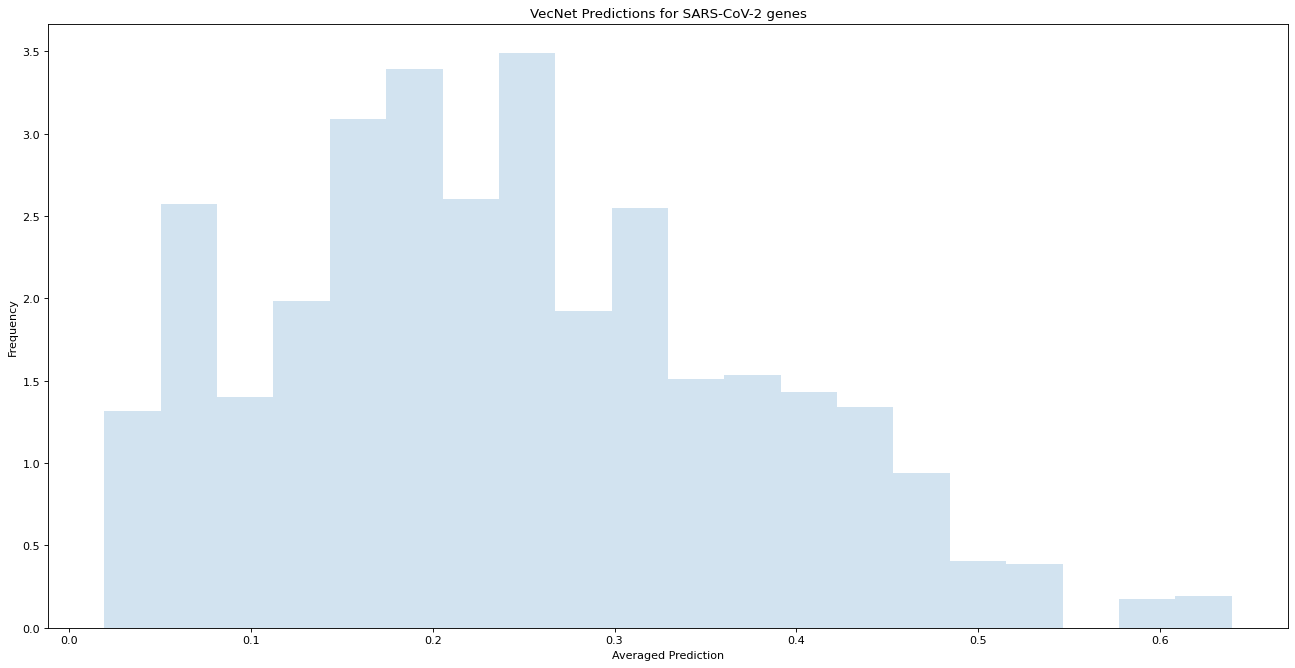

In [101]:
figure(figsize=(20, 10), dpi=80)
plt.hist(target_preidcitons_5fold_average[0]['Averaged Predictions'].tolist(),density=True,alpha=0.2,bins=20)
plt.xlabel('Averaged Prediction')
plt.ylabel('Frequency')
plt.title('VecNet Predictions for Unseen Targets')

In [100]:
target_preidcitons_5fold_average[0].to_csv('dump_file_csv')

### Prediction on Unseen Nodes

In [2]:
with open('VecNet_unseen_nodes.pickle', 'rb') as file:
    vecnet_object = pkl.load(file) 

In [24]:
## Expected to have 'InChiKey', 'SMILE', and 'target_aa_code'

nodes_df = pd.read_csv('csv_file_path')

# Example entries
#nodes_df['InChiKey'] = ['HUMNYLRZRPPJDN-UHFFFAOYSA-N']
#nodes_df['SMILE'] = ['C1=CC=C(C=C1)C=O']
#nodes_df['target_aa_code'] = sars_targets['Sequence'].tolist()[0]

In [26]:
unseen_nodes_example_5fold_average = vecnet_object.get_fold_averaged_prediction_results( model_name = None,
                                                                                     version_number = None,
                                                                                     model_paths = [],
                                                                                     optimal_validation_model = None,
                                                                                     test_sets = [nodes_df],
                                                                                     get_drug_embed = True,
                                                                                     get_target_embed = True,
                                                                                     drug_filter_list = [],
                                                                                     target_filter_list = [],
                                                                                     return_dataframes = True )


Testing on model :  ./VecNet_Unseen_Nodes/Run_0/vecnet_ds2_5_fold_unseen_nodes_v00_run0_06-15_04h42_epoch_19_idx_0.model
filtered_nodes_test :  (1, 3)
Drugs :  1
Targets :  1


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (1, 100) (1, 300)
Testing on model :  ./VecNet_Unseen_Nodes/Run_1/vecnet_ds2_5_fold_unseen_nodes_v00_run1_06-15_04h46_epoch_19_idx_0.model
filtered_nodes_test :  (1, 3)
Drugs :  1
Targets :  1


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (1, 100) (1, 300)
Testing on model :  ./VecNet_Unseen_Nodes/Run_2/vecnet_ds2_5_fold_unseen_nodes_v00_run2_06-15_04h50_epoch_19_idx_0.model
filtered_nodes_test :  (1, 3)
Drugs :  1
Targets :  1


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (1, 100) (1, 300)
Testing on model :  ./VecNet_Unseen_Nodes/Run_3/vecnet_ds2_5_fold_unseen_nodes_v00_run3_06-15_04h54_epoch_19_idx_0.model
filtered_nodes_test :  (1, 3)
Drugs :  1
Targets :  1


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (1, 100) (1, 300)
Testing on model :  ./VecNet_Unseen_Nodes/Run_4/vecnet_ds2_5_fold_unseen_nodes_v00_run4_06-15_04h56_epoch_19_idx_0.model
filtered_nodes_test :  (1, 3)
Drugs :  1
Targets :  1


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (1, 100) (1, 300)
unseen_targets_pred :  (1,)
list :  1


In [3]:
unseen_nodes_example_5fold_average[0].to_csv('dump_file_csv')